# Flux Gaussian Process

As we saw in the [previous tutorial]() (and [this]() and [this]() papers), it might be interesting to analyze an ensemble of light curves in order to infer the surface properties of a population of stars, especially given how little information is available in single broadband light curves. 

In the [previous tutorial]() we first defined a Gaussian process on the surface and generated samples to compute some global properties (such as the amplitude distribution of the light curves). But doing inference on light curve data requires a Gaussian process on the flux directly, conditioned on the surface properties.

In this tutorial, we describe the [FluxKernel]() featured in spotter, which allow to compute the likelihood of an ensemble of light curves given a Gaussian process on their surface.

```{important}
The features shown in this tutotrial are still experimental and not tested against ground truth. Use with care!
```

## The surface kernel

We start by defining the surface kernel, which provide a stochastic model for the surface parametrized by the 'spots' contrast and size here.

First, whenever using the [FluxKernel](), we recommend working in double precision to avoid numerical issues.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)

The GP can be defined as follows

In [2]:
import tinygp
import numpy as np
from spotter.kernels import GreatCircleDistance
from spotter import Star, show

star = Star.from_sides(2**4, inc=1.9, period=2 * np.pi)
surface_kernel = 0.01 * tinygp.kernels.Matern52(0.3, distance=GreatCircleDistance())
surface_gp = tinygp.GaussianProcess(surface_kernel, star.x)

/Users/lgarcia/code/spotter/spotter/star.py:48: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return cls(y, **kwargs)


We can then sample a surface realization and show it

/Users/lgarcia/code/spotter/spotter/star.py:72: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return self.__class__(y, self.u, self.inc, self.period)


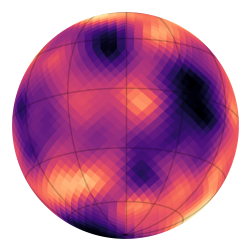

In [3]:
import matplotlib.pyplot as plt

star = star + surface_gp.sample(jax.random.PRNGKey(2), shape=(1,))[0]

plt.figure(figsize=(3, 3))
show(star)

## The flux kernel

From there, let's define a flux kernel, which takes as input the surface kernel and some of its properties

In [4]:
from spotter.kernels import FluxKernel

flux_kernel = FluxKernel(star.sides, surface_kernel, inc=star.inc, normalized=False)

Let's then defined a Gaussian process on the flux and sample a bunch of light curves

In [5]:
time = np.linspace(0, 4 * np.pi, 200)
flux_gp = tinygp.GaussianProcess(flux_kernel, time, mean=1.0)

lcs = flux_gp.sample(jax.random.PRNGKey(3), shape=(10,))

These correspond to the light curves of stars whose surface properties are given by the surface kernel we defined earlier. Let's plot these

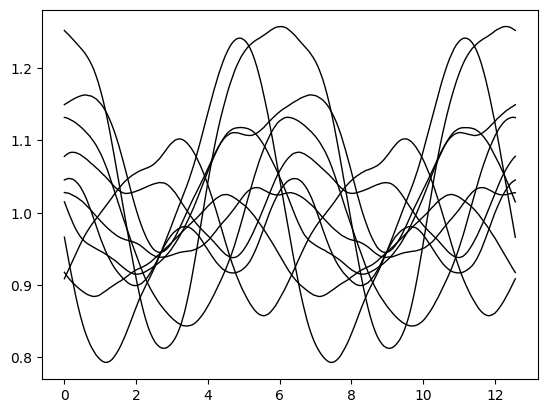

In [6]:
import matplotlib.pyplot as plt

_ = plt.plot(time, lcs.T, c="k", lw=1)

We notice that these aren't normalized, as we expect stars with different level of spottedness to have different mean magnitudes. Following [Luger et al. 2022](), we can define a normalized Gaussian Process by instantiating the [FluxKernel]() with `normalized=True` (the default).

## Inclination marginalization


The light curves previously drawn are all coming from a star with a given inclination, which is very unlikely. Indeed, in practice, the inclination of each star in the ensemble is mostly unknown. As in [Luger et al. 2022](), we can define a flux kernel marginalized over the stellar inclinations. To do that, one simply has to omit specifying the inclination in the flux kernel

In [7]:
flux_kernel_marginalized = FluxKernel(star.sides, surface_kernel)
flux_gp_marginalized = tinygp.GaussianProcess(flux_kernel_marginalized, time)

Again let sample light curves, but this time compare the amplitude distribution of the fixed inclination case with the marginalized one

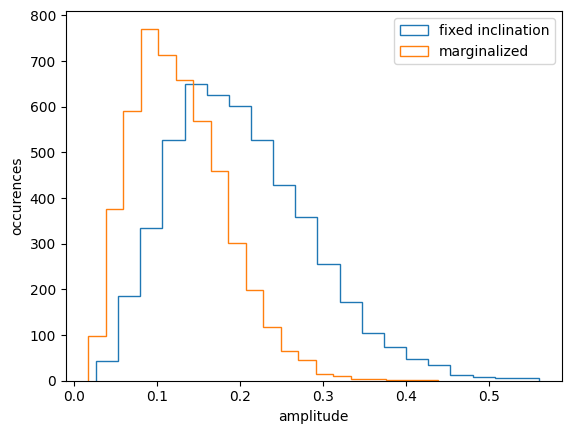

In [8]:
n = 5000
lcs = flux_gp.sample(jax.random.PRNGKey(3), shape=(n,))
lcs_marginalized = flux_gp_marginalized.sample(jax.random.PRNGKey(3), shape=(n,))

amplitudes = np.ptp(lcs, axis=1)
amplitudes_marginalized = np.ptp(lcs_marginalized, axis=1)

plt.hist(amplitudes, bins=20, histtype="step", label="fixed inclination")
plt.hist(amplitudes_marginalized, bins=20, histtype="step", label="marginalized")
plt.xlabel("amplitude")
plt.ylabel("occurences")
_ = plt.legend()

As expected, the light curves drawn from a kernel marginalized over the inclination have lower amplitudes, due to lower inclinations being better represented by the sample.

This way, the [FluxKernel]() can be used to infer the surface properties of an ensemble of stars with unknown inclinations (see the [inference tutorial]()).